# Train NN model

In this notebook we pick one NN architectures model, and initialise it as the generator to use in training and inference. Then we train the previously defined and initialised NN model, and check the results running inference on the test dataset.

This notebook is split in the following parts:

- 1) **Preprocessing**, where we convert the dataset to torch, split it into train and test set, normalise it in the range [0,1] (for NN convergence reasons) and create dataloader objects
- 2) **Generator**, where we initialise one of the defined models as the generator to use in training and inference
- 3) **Pre-training generation**, sanity check: where we make inference on test data using the untrained network
- 4) **Training**, where we train the NN, save the weigths and plot losses curves
- 5) **Inferece**, where we generate data for main channel from the test dataset. We also plot the generated data and compare it to the target

## Run imports and define useful functions

In [1]:
%run ./import.ipynb

#### Check the GPU is available in torch

In [2]:
if torch.cuda.is_available():
    device = 'cuda'
    print(torch.cuda.get_device_name(torch.cuda.current_device()))
else:
    device = 'cpu'

NVIDIA A100-PCIE-40GB MIG 3g.20gb


In [3]:
device

'cuda'

#### Define functions

In [4]:
%run ./utils.ipynb
%run ./models.ipynb ## Contains all NN architectures and functions for training

## Initialisation

In [69]:
#nb_aux_channels = 1 
#nb_aux_channels = 2
nb_aux_channels = 3
#nb_aux_channels = 5

ratio = 0.1 # Test/Training ratio - default 0.2
batch_size = 20
norm = True
size = 64 # image size
zmax = 1
ntot_k = 50#k

## Preprocessing

In [70]:
#Load data from .pkl
file_path='/data/datasets/intertwin_synt/image_'+str(nb_aux_channels)+'aux_'+str(ntot_k)+'k.pkl'
df = pd.read_pickle(file_path)
df.shape

(50000, 4)

In [71]:
#split training/test
train_data_2d, test_data_2d = split_(df, ratio)

Train: torch.Size([45000, 4, 64, 64])
Test: torch.Size([5000, 4, 64, 64])


In [72]:
#normalise to 1
train_data_2d = normalize_(train_data_2d, nb_aux_channels+1)
test_data_2d = normalize_(test_data_2d, nb_aux_channels+1)

In [73]:
#Create dataloader objects with preprocessed dataset
dataloader = DataLoader(train_data_2d, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data_2d, batch_size=batch_size, shuffle=False)

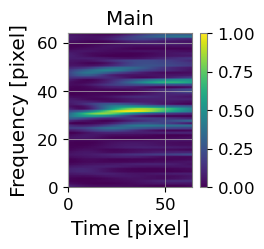

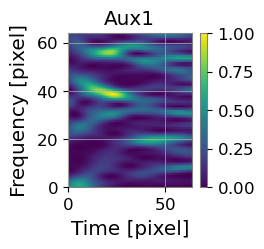

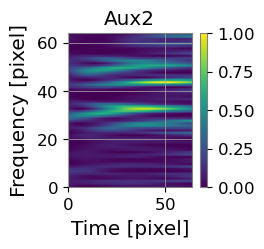

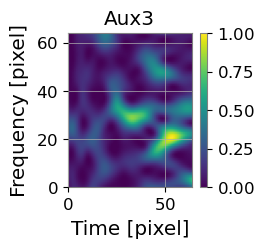

In [74]:
#visualize normalised data
nb_event = 0

qplt=test_data_2d[nb_event,0].detach().cpu().numpy()
qplot(qplt, "Main", size, zmax, 2)

for j in range(1,nb_aux_channels+1):
    qplt=test_data_2d[nb_event,j].detach().cpu().numpy()
    qplot(qplt, "Aux"+str(j), size, zmax, 2)

## Generator model architecture

In [75]:
### RESNET
# doesn't work with 1 aux channel
'''
try:
    del generator_2d
    print('generator_2d deleted')
except:
    pass

generator_2d=GeneratorResNet(nb_aux_channels,12,1).to(device) # RESNET
init_weights(generator_2d, 'normal', scaling=0.01)

print(generator_2d)'''

"\ntry:\n    del generator_2d\n    print('generator_2d deleted')\nexcept:\n    pass\n\ngenerator_2d=GeneratorResNet(nb_aux_channels,12,1).to(device) # RESNET\ninit_weights(generator_2d, 'normal', scaling=0.01)\n\nprint(generator_2d)"

In [86]:
# DEEPER DECODER

try:
    del generator_2d
    print('generator_2d deleted')
except:
    pass

generator_2d=Decoder_2d_deep(nb_aux_channels).to(device)

init_weights(generator_2d, 'normal', scaling=.02)
print(generator_2d)

generator_2d deleted
initialize network with normal
Decoder_2d_deep(
  (conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu1): LeakyReLU(negative_slope=0.3, inplace=True)
  (conv2): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu2): LeakyReLU(negative_slope=0.3, inplace=True)
  (conv3): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu3): LeakyReLU(negative_slope=0.3, inplace=True)
  (conv4): Conv2d(256, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (activation): Sigmoid()
)


## Pre-training generation

- check initialisation

In [87]:
for batch in(tqdm(test_dataloader)):
    generated=generate_data(generator_2d,batch,normalize=False)
    break
    
generated.shape
#batch=transform(batch)

  0%|          | 0/250 [00:00<?, ?it/s]


torch.Size([20, 1, 64, 64])

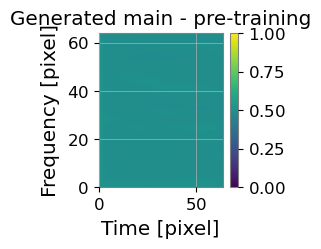

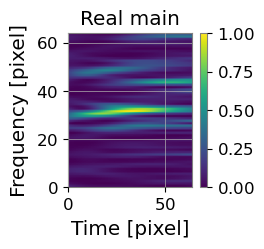

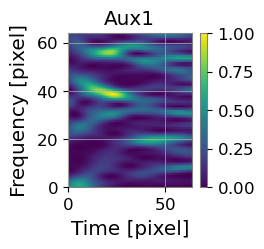

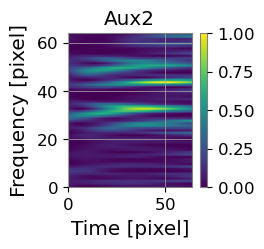

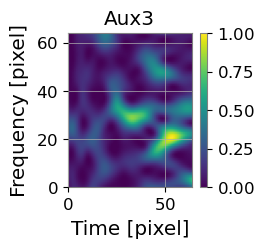

In [88]:
nb_event=0

qplt_g=generated[nb_event,0].detach().cpu().numpy() # generated Main
qplot(qplt_g, "Generated main - pre-training", size, zmax, 2)

qplt_r=batch[nb_event,0].detach().cpu().numpy() # Real Main
qplot(qplt_r, "Real main", size, zmax, 2)

for j in range(1,nb_aux_channels+1):
    qplt=batch[nb_event,j].detach().cpu().numpy()
    qplot(qplt, "Aux"+str(j), size, zmax, 2)

## Actual training

In [89]:
# loss function, learning rate, and optimiser
l2_loss = nn.MSELoss() #this is l2!!!
l1_loss = nn.L1Loss()  #this is L1!!!
loss=l1_loss
#lr=0.00005 Decoder 1 aux
#lr=0.0000005 #ResNet
lr=0.0000005

G_optimizer = torch.optim.Adam(generator_2d.parameters(), lr=lr )

n_epochs=50

In [90]:
loss_plot, val_loss_plot,acc_plot, val_acc_plot=train_decoder(n_epochs,generator_2d,loss,G_optimizer,
        dataloader,test_dataloader)

  2%|▏         | 1/50 [00:50<41:03, 50.27s/it]

epoch: 1 loss: 0.17567139863967896 val loss: 0.09119322150945663 time:50.27388381958008s


  4%|▍         | 2/50 [01:40<40:11, 50.25s/it]

epoch: 2 loss: 0.08956941962242126 val loss: 0.08741600066423416 time:50.224480628967285s


  6%|▌         | 3/50 [02:30<39:20, 50.23s/it]

epoch: 3 loss: 0.08150392025709152 val loss: 0.074571393430233 time:50.21072602272034s


  8%|▊         | 4/50 [03:20<38:30, 50.22s/it]

epoch: 4 loss: 0.07304501533508301 val loss: 0.07179027795791626 time:50.212499141693115s


 10%|█         | 5/50 [04:11<37:40, 50.23s/it]

epoch: 5 loss: 0.0707869604229927 val loss: 0.06968063116073608 time:50.24203419685364s


 12%|█▏        | 6/50 [05:01<36:50, 50.24s/it]

epoch: 6 loss: 0.0688616931438446 val loss: 0.06797513365745544 time:50.24710822105408s


 14%|█▍        | 7/50 [05:51<36:00, 50.24s/it]

epoch: 7 loss: 0.06743127852678299 val loss: 0.06678161770105362 time:50.24055480957031s


 16%|█▌        | 8/50 [06:41<35:10, 50.25s/it]

epoch: 8 loss: 0.06645631790161133 val loss: 0.06600403785705566 time:50.28699493408203s


 18%|█▊        | 9/50 [07:32<34:20, 50.26s/it]

epoch: 9 loss: 0.06583083420991898 val loss: 0.0655004009604454 time:50.28222990036011s


 20%|██        | 10/50 [08:22<33:30, 50.27s/it]

epoch: 10 loss: 0.06543697416782379 val loss: 0.06518518924713135 time:50.28389358520508s


 22%|██▏       | 11/50 [09:12<32:41, 50.28s/it]

epoch: 11 loss: 0.06517612189054489 val loss: 0.06496273726224899 time:50.312747955322266s


 24%|██▍       | 12/50 [10:03<31:51, 50.29s/it]

epoch: 12 loss: 0.06497962772846222 val loss: 0.06484378129243851 time:50.319167613983154s


 26%|██▌       | 13/50 [10:53<31:00, 50.28s/it]

epoch: 13 loss: 0.06483674794435501 val loss: 0.0646718218922615 time:50.242756605148315s


 28%|██▊       | 14/50 [11:43<30:09, 50.27s/it]

epoch: 14 loss: 0.06472132354974747 val loss: 0.06456875801086426 time:50.2434663772583s


 30%|███       | 15/50 [12:33<29:19, 50.26s/it]

epoch: 15 loss: 0.06462765485048294 val loss: 0.06447792053222656 time:50.234580993652344s


 32%|███▏      | 16/50 [13:24<28:28, 50.24s/it]

epoch: 16 loss: 0.06454554200172424 val loss: 0.06440436094999313 time:50.206236839294434s


 34%|███▍      | 17/50 [14:14<27:37, 50.23s/it]

epoch: 17 loss: 0.06447132676839828 val loss: 0.06432986259460449 time:50.21225833892822s


 36%|███▌      | 18/50 [15:04<26:47, 50.23s/it]

epoch: 18 loss: 0.06440630555152893 val loss: 0.06426782160997391 time:50.211644649505615s


 38%|███▊      | 19/50 [15:54<25:57, 50.24s/it]

epoch: 19 loss: 0.0643450915813446 val loss: 0.06421057134866714 time:50.26393461227417s


 40%|████      | 20/50 [16:45<25:07, 50.25s/it]

epoch: 20 loss: 0.06428973376750946 val loss: 0.06415761262178421 time:50.267887115478516s


 42%|████▏     | 21/50 [17:35<24:17, 50.26s/it]

epoch: 21 loss: 0.06423818320035934 val loss: 0.06410668790340424 time:50.28063941001892s


 44%|████▍     | 22/50 [18:25<23:27, 50.26s/it]

epoch: 22 loss: 0.06419060379266739 val loss: 0.06406040489673615 time:50.27454328536987s


 46%|████▌     | 23/50 [19:15<22:37, 50.26s/it]

epoch: 23 loss: 0.06414471566677094 val loss: 0.06402362138032913 time:50.2599093914032s


 48%|████▊     | 24/50 [20:06<21:46, 50.26s/it]

epoch: 24 loss: 0.06410243362188339 val loss: 0.06397721916437149 time:50.25804114341736s


 50%|█████     | 25/50 [20:56<20:56, 50.26s/it]

epoch: 25 loss: 0.06405922025442123 val loss: 0.06400406360626221 time:50.26620960235596s


 52%|█████▏    | 26/50 [21:46<20:06, 50.27s/it]

epoch: 26 loss: 0.0640225037932396 val loss: 0.06389938294887543 time:50.27297401428223s


 54%|█████▍    | 27/50 [22:36<19:16, 50.27s/it]

epoch: 27 loss: 0.06398577243089676 val loss: 0.06386668980121613 time:50.26694869995117s


 56%|█████▌    | 28/50 [23:27<18:25, 50.26s/it]

epoch: 28 loss: 0.06395135074853897 val loss: 0.06383725255727768 time:50.25114464759827s


 58%|█████▊    | 29/50 [24:17<17:35, 50.24s/it]

epoch: 29 loss: 0.06391683965921402 val loss: 0.06380334496498108 time:50.19881558418274s


 60%|██████    | 30/50 [25:07<16:44, 50.22s/it]

epoch: 30 loss: 0.06389068067073822 val loss: 0.06377792358398438 time:50.14860224723816s


 62%|██████▏   | 31/50 [25:57<15:53, 50.20s/it]

epoch: 31 loss: 0.06386011093854904 val loss: 0.06374463438987732 time:50.16144061088562s


 64%|██████▍   | 32/50 [26:47<15:03, 50.19s/it]

epoch: 32 loss: 0.06383173167705536 val loss: 0.06371724605560303 time:50.162769079208374s


 66%|██████▌   | 33/50 [27:38<14:13, 50.19s/it]

epoch: 33 loss: 0.06380393356084824 val loss: 0.063717782497406 time:50.18194937705994s


 68%|██████▊   | 34/50 [28:28<13:23, 50.20s/it]

epoch: 34 loss: 0.06377806514501572 val loss: 0.0636838749051094 time:50.244300842285156s


 70%|███████   | 35/50 [29:18<12:33, 50.23s/it]

epoch: 35 loss: 0.06375303864479065 val loss: 0.06365698575973511 time:50.29296898841858s


 72%|███████▏  | 36/50 [30:08<11:43, 50.25s/it]

epoch: 36 loss: 0.06373214721679688 val loss: 0.06362798064947128 time:50.296539306640625s


 74%|███████▍  | 37/50 [30:59<10:53, 50.26s/it]

epoch: 37 loss: 0.06370511651039124 val loss: 0.06362801790237427 time:50.269309759140015s


 76%|███████▌  | 38/50 [31:49<10:03, 50.26s/it]

epoch: 38 loss: 0.06368165463209152 val loss: 0.06359420716762543 time:50.25729584693909s


 78%|███████▊  | 39/50 [32:39<09:12, 50.26s/it]

epoch: 39 loss: 0.06366086006164551 val loss: 0.06356142461299896 time:50.261600732803345s


 80%|████████  | 40/50 [33:29<08:22, 50.26s/it]

epoch: 40 loss: 0.0636369064450264 val loss: 0.06354187428951263 time:50.254109382629395s


 82%|████████▏ | 41/50 [34:20<07:32, 50.26s/it]

epoch: 41 loss: 0.06361743062734604 val loss: 0.06351354718208313 time:50.25795388221741s


 84%|████████▍ | 42/50 [35:10<06:42, 50.26s/it]

epoch: 42 loss: 0.0635935440659523 val loss: 0.06349553912878036 time:50.25826954841614s


 86%|████████▌ | 43/50 [36:00<05:51, 50.26s/it]

epoch: 43 loss: 0.0635770931839943 val loss: 0.06348405033349991 time:50.259252309799194s


 88%|████████▊ | 44/50 [36:50<05:01, 50.26s/it]

epoch: 44 loss: 0.06355910003185272 val loss: 0.06345999240875244 time:50.258501052856445s


 90%|█████████ | 45/50 [37:41<04:11, 50.27s/it]

epoch: 45 loss: 0.0635424554347992 val loss: 0.06346915662288666 time:50.29889178276062s


 92%|█████████▏| 46/50 [38:31<03:21, 50.28s/it]

epoch: 46 loss: 0.06352398544549942 val loss: 0.06342647224664688 time:50.303868770599365s


 94%|█████████▍| 47/50 [39:21<02:30, 50.26s/it]

epoch: 47 loss: 0.06350713968276978 val loss: 0.0634111687541008 time:50.21768236160278s


 96%|█████████▌| 48/50 [40:11<01:40, 50.25s/it]

epoch: 48 loss: 0.0634925365447998 val loss: 0.06339406222105026 time:50.221198081970215s


 98%|█████████▊| 49/50 [41:02<00:50, 50.24s/it]

epoch: 49 loss: 0.06347662955522537 val loss: 0.06337941437959671 time:50.221816062927246s


100%|██████████| 50/50 [41:52<00:00, 50.25s/it]

epoch: 50 loss: 0.0634600818157196 val loss: 0.06338749825954437 time:50.231826066970825s


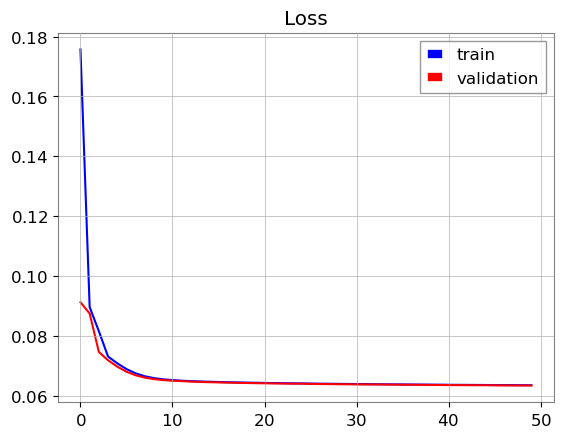

In [91]:
# Plotting the loss
import matplotlib.pyplot as plt
plt.plot(loss_plot,color='b',label='train')
plt.plot(val_loss_plot,color='r',label='validation')
plt.title('Loss')
plt.legend()
#plt.savefig('lc.pdf')
#plt.yscale('log')
plt.show()

In [92]:
#save model
model = type(generator_2d).__name__
model_scripted = torch.jit.script(generator_2d) # Export to TorchScript

model_scripted.save('model/model_'+model+'_'+str(nb_aux_channels)+'aux.pt') # Save

## Inference

In [93]:
#make inference on test data
for batch in(tqdm(test_dataloader)):
    generated=generate_data(generator_2d,batch,normalize=False)
    break

generated.shape

  0%|          | 0/250 [00:00<?, ?it/s]


torch.Size([20, 1, 64, 64])

#### Plot Real, Generated and input Qplots

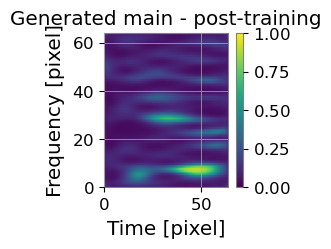

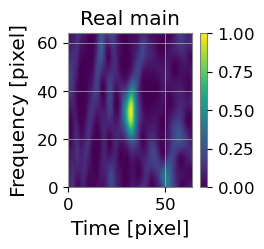

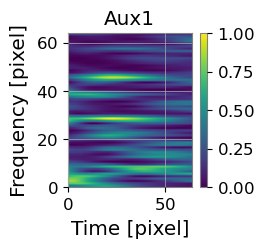

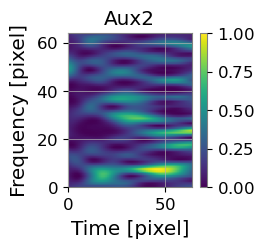

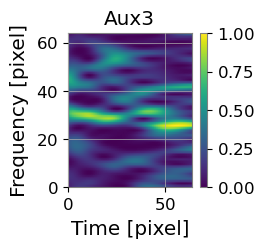

In [94]:
nb_event=10

qplt_g=generated[nb_event,0].detach().cpu().numpy() # generated Main
qplot(qplt_g, "Generated main - post-training", size, zmax, 2)

qplt_r=batch[nb_event,0].detach().cpu().numpy() # Real Main
qplot(qplt_r, "Real main", size, zmax, 2)

for j in range(1,nb_aux_channels+1):
    qplt=batch[nb_event,j].detach().cpu().numpy()
    qplot(qplt, "Aux"+str(j), size, zmax, 2)

---------------------------
IMAGE 0


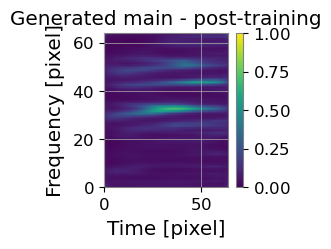

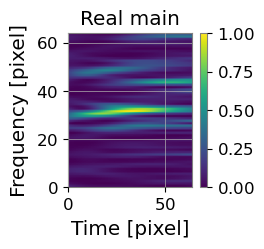

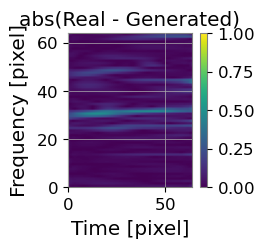

---------------------------
IMAGE 1


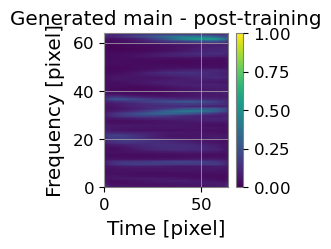

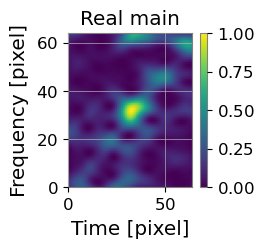

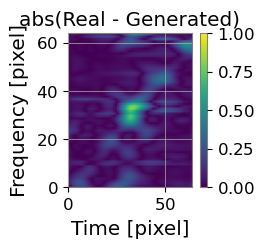

---------------------------
IMAGE 2


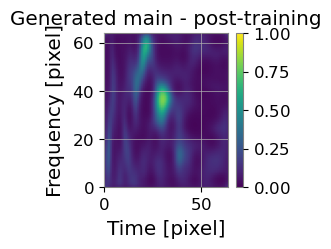

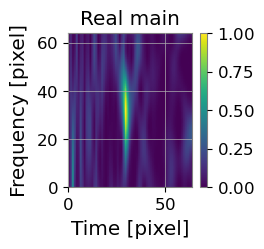

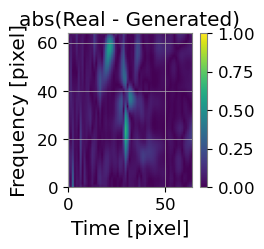

---------------------------
IMAGE 3


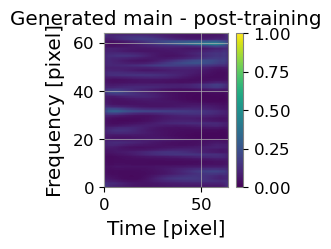

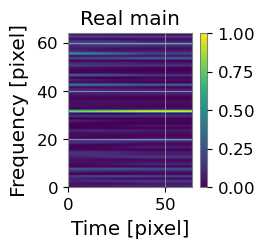

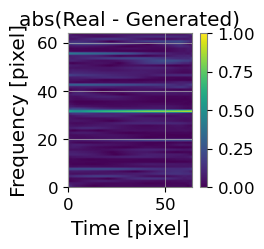

---------------------------
IMAGE 4


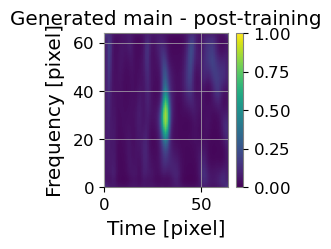

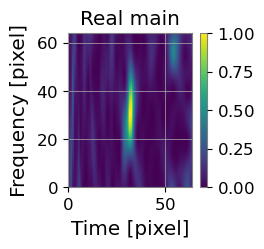

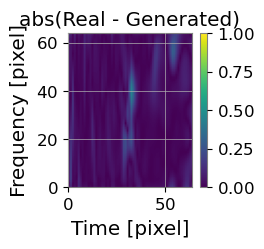

---------------------------
IMAGE 5


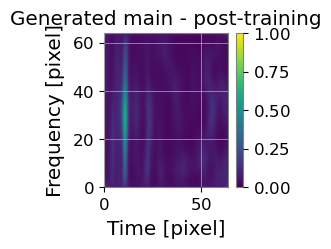

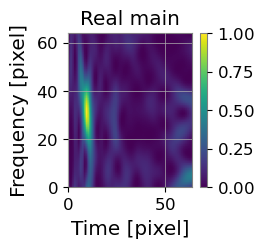

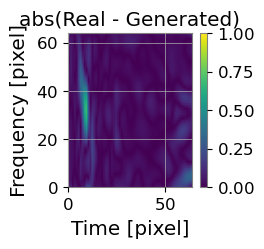

---------------------------
IMAGE 6


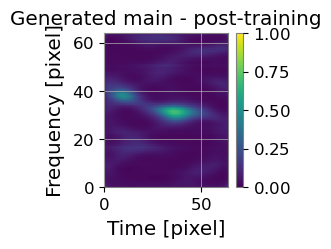

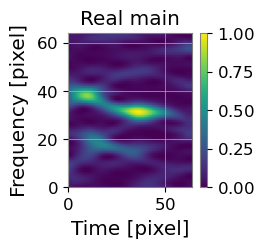

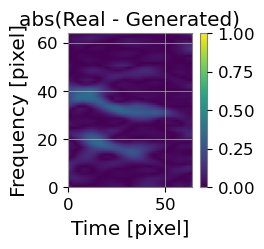

---------------------------
IMAGE 7


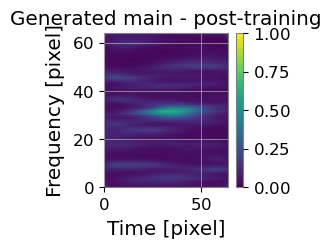

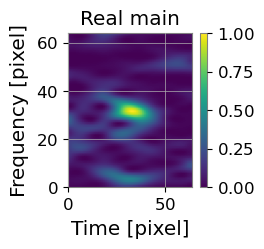

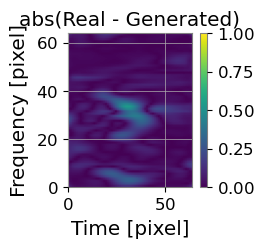

---------------------------
IMAGE 8


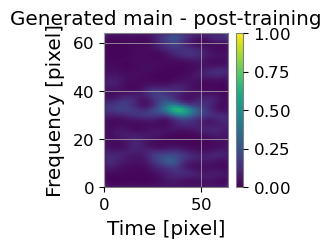

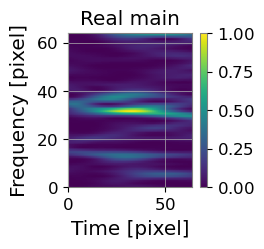

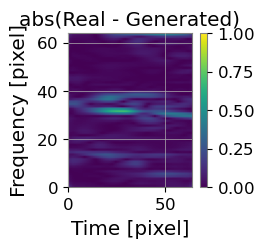

---------------------------
IMAGE 9


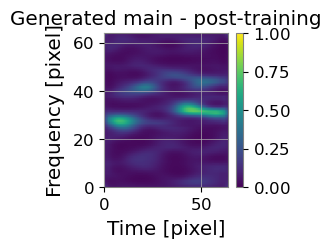

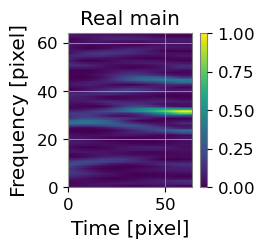

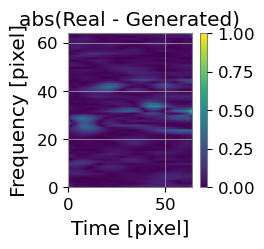

---------------------------
IMAGE 10


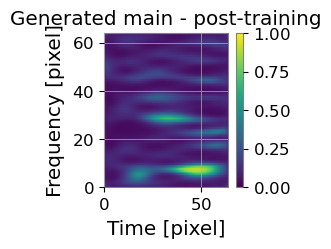

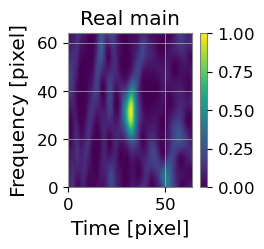

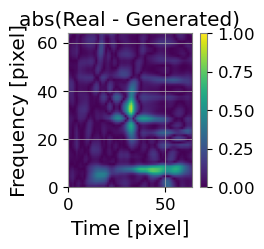

---------------------------
IMAGE 11


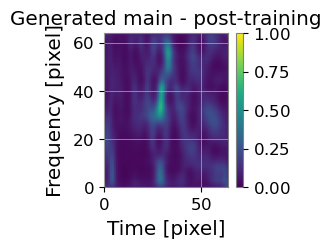

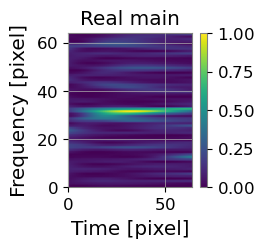

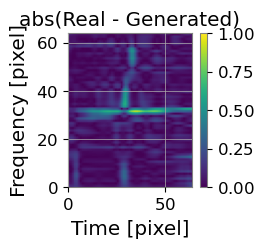

---------------------------
IMAGE 12


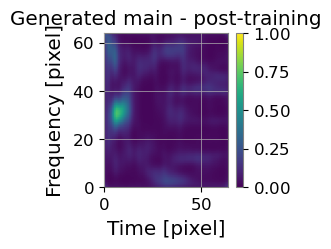

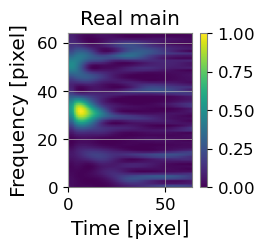

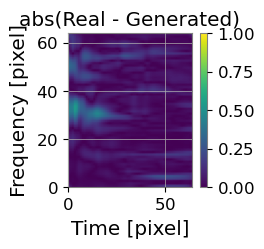

---------------------------
IMAGE 13


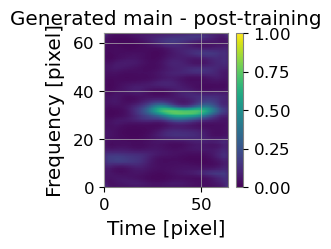

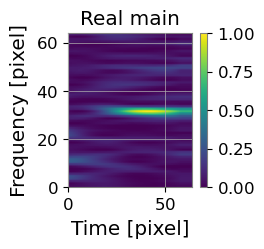

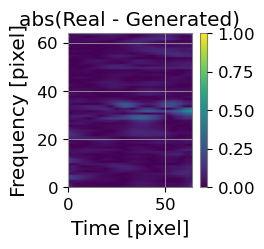

---------------------------
IMAGE 14


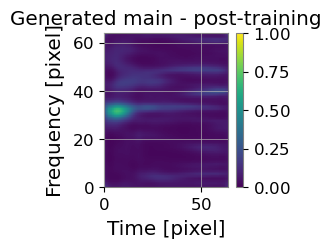

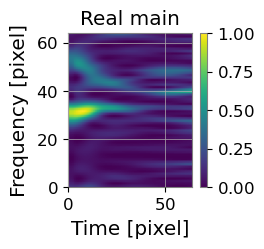

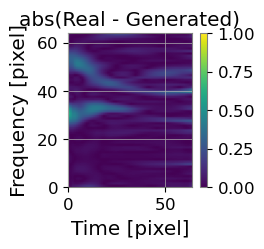

---------------------------
IMAGE 15


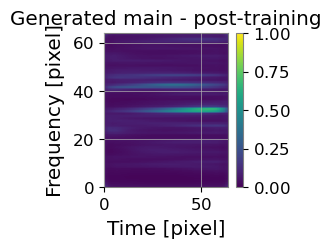

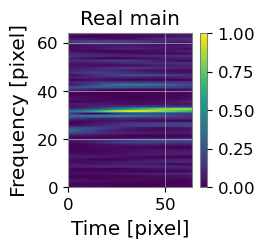

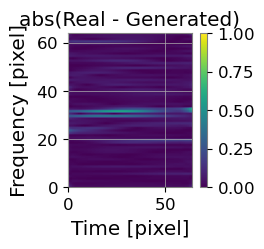

---------------------------
IMAGE 16


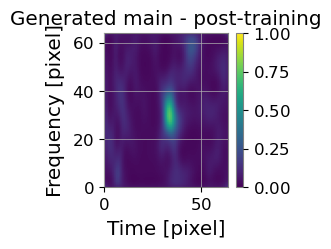

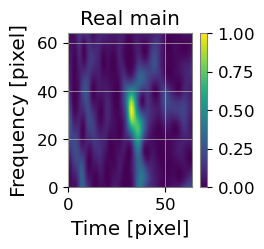

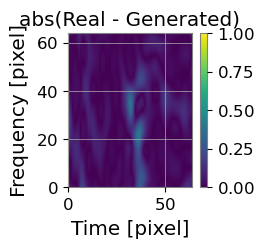

---------------------------
IMAGE 17


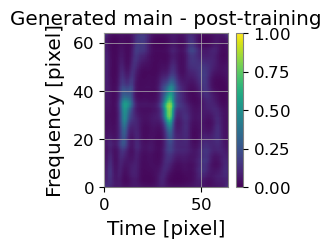

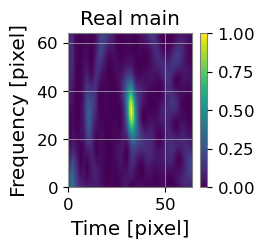

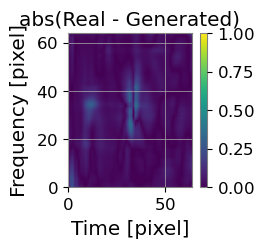

---------------------------
IMAGE 18


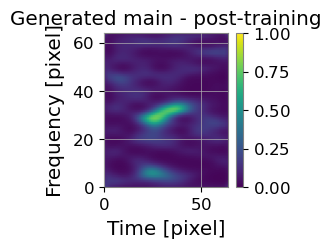

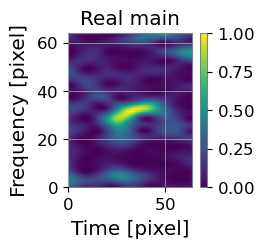

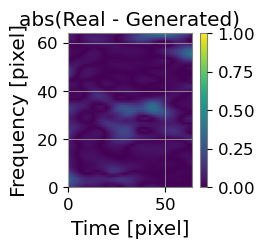

---------------------------
IMAGE 19


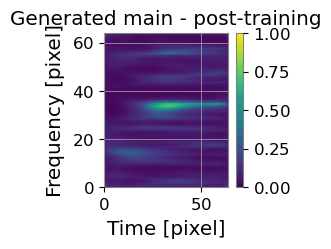

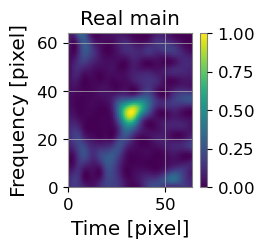

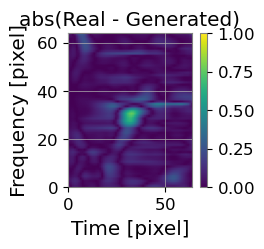

In [95]:
for i in range(generated.shape[0]):
    print('---------------------------')
    print(f'IMAGE {i}')

    qplt_g=generated[i,0].detach().cpu().numpy() # generated Main
    qplot(qplt_g, "Generated main - post-training", size, zmax, 2)

    qplt_r=batch[i,0].detach().cpu().numpy() # Real Main
    qplot(qplt_r, "Real main", size, zmax, 2)
    
    qplot(abs(qplt_g-qplt_r), "abs(Real - Generated)", size, zmax, 2) # Difference Main  

#    for j in range(1,nb_aux_channels+1):
#        qplt=batch[i,j].detach().cpu().numpy()
#        qplot(qplt, "Aux"+str(j), size, zmax, 2)

In [96]:

print("Number of cpu : ", multiprocessing.cpu_count())



Number of cpu :  32


In [97]:
len(os.sched_getaffinity(0))

32